In [2]:
from pprint import PrettyPrinter
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import config

import warnings
warnings.filterwarnings('ignore')

In [4]:
# connecting to a local db
client=MongoClient(host="localhost", port=27017)

In [5]:
# instantiate prettyprinter
pp=PrettyPrinter(indent=2)

# Explore

In [6]:
# viewing DBs present
list(client.list_databases())

[{'name': 'admin', 'sizeOnDisk': 40960, 'empty': False},
 {'name': 'airquality', 'sizeOnDisk': 63324160, 'empty': False},
 {'name': 'config', 'sizeOnDisk': 98304, 'empty': False},
 {'name': 'local', 'sizeOnDisk': 73728, 'empty': False}]

In [7]:
db=client["airquality"]

In [8]:
# view collections
for collection in db.list_collections():
    print(collection["name"])

nairobi


In [9]:
# connect to a collection
mycol=db[config.collection]

In [10]:
#number of documents in the database
mycol.count_documents({}) 

1572473

In [11]:
# viewing one doc
result=mycol.find_one({})
pp.pprint(result)

{ '_id': ObjectId('65deef7b8a5bd3df1bb4974a'),
  'lat': -1.3,
  'location': 29,
  'lon': 36.785,
  'sensor_id': 57,
  'sensor_type': 'SDS011',
  'timestamp': datetime.datetime(2018, 12, 1, 0, 0, 6, 767000),
  'value': 17.08,
  'value_type': 'P1'}


In [12]:
# types of readings
mycol.distinct('value_type')

['P1',
 'P2',
 'height',
 'humidity',
 'lat',
 'lon',
 'max_micro',
 'min_micro',
 'samples',
 'temperature',
 'timestamp']

In [13]:
result=mycol.find({"value_type":"P2"}).limit(3)

pp.pprint(list(result))

[ { '_id': ObjectId('65deef7b8a5bd3df1bb4974b'),
    'lat': -1.3,
    'location': 29,
    'lon': 36.785,
    'sensor_id': 57,
    'sensor_type': 'SDS011',
    'timestamp': datetime.datetime(2018, 12, 1, 0, 0, 6, 767000),
    'value': 8.07,
    'value_type': 'P2'},
  { '_id': ObjectId('65deef7b8a5bd3df1bb4974f'),
    'lat': -1.293,
    'location': 40,
    'lon': 36.769,
    'sensor_id': 61,
    'sensor_type': 'SDS011',
    'timestamp': datetime.datetime(2018, 12, 1, 0, 0, 15, 914000),
    'value': 8.7,
    'value_type': 'P2'},
  { '_id': ObjectId('65deef7b8a5bd3df1bb49751'),
    'lat': -1.29,
    'location': 30,
    'lon': 36.777,
    'sensor_id': 79,
    'sensor_type': 'SDS011',
    'timestamp': datetime.datetime(2018, 12, 1, 0, 0, 29, 137000),
    'value': 7.93,
    'value_type': 'P2'}]


In [14]:
# how many values are there per reading
result=mycol.aggregate([{"$group":{"_id":"$value_type", "count":{"$count":{}}}}])
pp.pprint(list(result))

[ {'_id': 'samples', 'count': 1},
  {'_id': 'humidity', 'count': 319670},
  {'_id': 'max_micro', 'count': 1},
  {'_id': 'height', 'count': 34},
  {'_id': 'min_micro', 'count': 1},
  {'_id': 'timestamp', 'count': 34},
  {'_id': 'P1', 'count': 466497},
  {'_id': 'lon', 'count': 34},
  {'_id': 'lat', 'count': 34},
  {'_id': 'P2', 'count': 466497},
  {'_id': 'temperature', 'count': 319670}]


There are 466497 readings for PM2.5.

In [15]:
# retrieve the PM 2.5 readings
result=mycol.find(
    
    {"value_type":"P2"},
    
    projection={"value":1, "timestamp":1, "_id":0} 
   )    


pp.pprint(result.next())

{'timestamp': datetime.datetime(2018, 12, 1, 0, 0, 6, 767000), 'value': 8.07}


In [16]:
df=pd.DataFrame(result).set_index('timestamp')
df.tail()

,value
timestamp,
2018-11-30 23:59:04.660,10.93
2018-11-30 23:59:21.460,0.00
2018-11-30 23:59:27.726,9.20
2018-11-30 23:59:35.957,7.67
2018-11-30 23:59:50.639,6.90


In [20]:
assert df.shape[1]==1, f"`df` should only have one column not {df.shape[1]}"

assert df.columns==["value"]

In [22]:
# looking at the distribution of 'P2'
df.value.describe()

count    466496.000000
mean         11.142075
std          38.764241
min           0.000000
25%           4.400000
50%           7.180000
75%          10.730000
max         939.900000
Name: value, dtype: float64

<Axes: title={'center': 'Distribution of PM2.5 Reading'}>

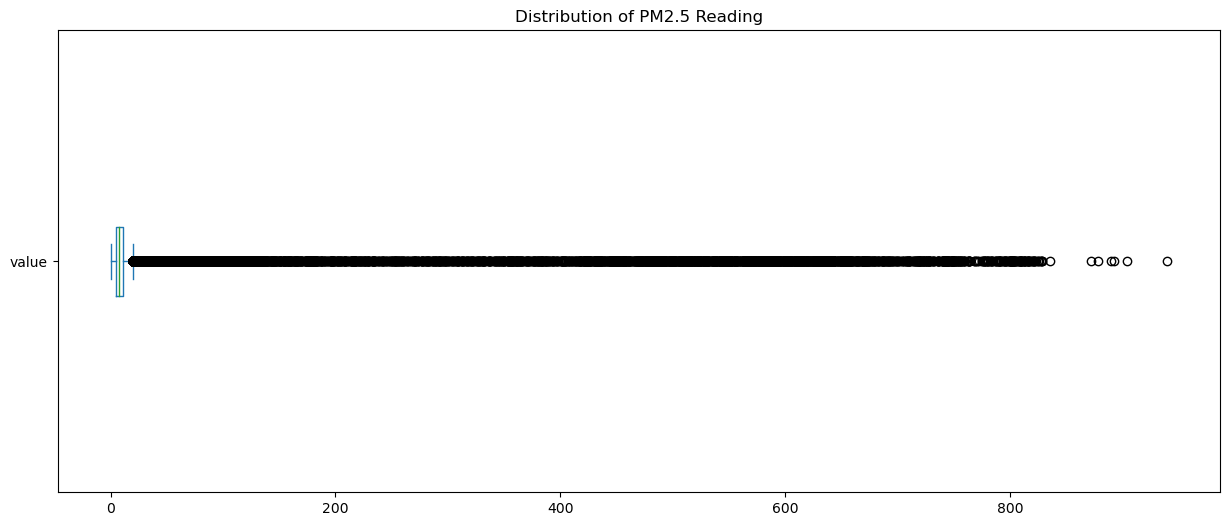

In [23]:
fig, ax=plt.subplots(figsize=(15,6))
df.value.plot(kind="box", vert= False, title="Distribution of PM2.5 Reading", ax=ax)

The PM2.5 reading dataset has outliers, the minimum value is 0.000000, the 75 percentile is 10.250000 while the maximum value is 939.900000.

In [ ]:
in this project I am predicting the average Pm2.5 reading hourly. I downloadel the data from openAfrica[`https://africaopendata.org/datasetm]